In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
# Load your data
data = pd.read_csv('data/stocks1.csv', index_col='Date', parse_dates=True)
# Compute daily returns
returns = data.pct_change().dropna()
print(returns.columns)
# Let's assume S&P index is in the first column
target_series = returns['AMZN']
features = returns.drop(columns=['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'])

Index(['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'], dtype='object')


In [3]:
#!pip install torch_geometric

In [4]:
# Compute correlation matrix
correlation_matrix = features.corr().values

# Create graph edges based on correlation
edge_index = np.array(np.nonzero(correlation_matrix > 0.5)).T  # Using 0.5 as a threshold
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
print(edge_index)
# Node features
x = torch.tensor(features.values, dtype=torch.float)

# Target: future values of the S&P index
y = torch.tensor(target_series.shift(-1).dropna().values, dtype=torch.float).unsqueeze(1)

# Update node features to match target length
x = x[:-1]  # Exclude the last row to match target length

# Define the graph data object
graph_data = Data(x=x, edge_index=edge_index)


tensor([], size=(2, 0), dtype=torch.int64)


In [5]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, loss, and optimizer
model = GCN(in_channels=graph_data.num_features, hidden_channels=16, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()


Epoch 0, Loss: 0.0005640679737553
Epoch 10, Loss: 0.0005829180008731782
Epoch 20, Loss: 0.0005707201780751348
Epoch 30, Loss: 0.0005645995843224227
Epoch 40, Loss: 0.0005636165151372552
Epoch 50, Loss: 0.000563537934795022
Epoch 60, Loss: 0.0005635461420752108
Epoch 70, Loss: 0.00056353589752689
Epoch 80, Loss: 0.0005634989938698709
Epoch 90, Loss: 0.0005634866538457572
Epoch 100, Loss: 0.000563488865736872
Epoch 110, Loss: 0.0005634863628074527
Epoch 120, Loss: 0.0005634866538457572
Epoch 130, Loss: 0.0005634864210151136
Epoch 140, Loss: 0.0005634863628074527
Epoch 150, Loss: 0.0005634864210151136
Epoch 160, Loss: 0.0005634864210151136
Epoch 170, Loss: 0.0005634864210151136
Epoch 180, Loss: 0.0005634863628074527
Epoch 190, Loss: 0.0005634863628074527


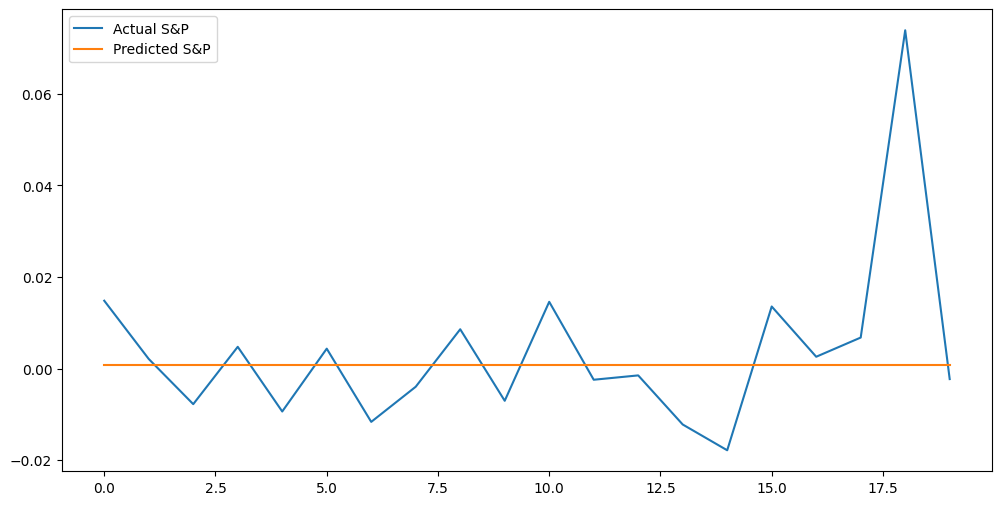

In [6]:
model.train()
num_epochs = 200

for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        
model.eval()
with torch.no_grad():
    predictions = model(graph_data.x, graph_data.edge_index).squeeze().numpy()

# Compare predictions with actual values
import matplotlib.pyplot as plt

actual_values = y.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(actual_values[0:20], label='Actual S&P')
plt.plot(predictions[0:20], label='Predicted S&P')
plt.legend()
plt.show()


In [7]:
# This work needs serious rework (possibly hyperparameter tuning) ++

In [8]:
# Draw graph network 
